# Tutorial on how to implement simple decoding with blazingly fast Pauli Frame sampling
This notebook will demonstrate and walk the reader through simulating simple errors on quantum error correcting circuits that are going to be run using the `QuantumClifford.jl` library's Pauli Frame simulation functionality. 
We will then evaluate that circuit's performance, however because of the way Pauli Frames are constructed, we will need to do this by modifying our circuit to measure the logical X and Z obserables and then seeing if a logical flip occurred.

## Assumptions
*  We have access to the encoding circuit of the code that we will be simulating
*  The reader has already gone through my other notebook, `Tutorial on how to implement simple decoding, using a quantum code with its encoding circuit`. This tutorial in many ways is simply building off of that one.

## Notes
*  Utilizing Pauli Frames results in massive speed ups and is the recomended (sometimes only) method when a large number of samples is desired. Another goal of this tutorial is provide a guide on how to use Pauli Frame simulation in `QuantumClifford.jl`.

In [48]:
using Revise
@time using QuantumClifford
@time using Quantikz
@time using QuantumClifford.ECC: Steane7, Shor9, naive_syndrome_circuit, encoding_circuit, parity_checks, code_s, code_n, faults_matrix
versioninfo()

  0.000171 seconds (212 allocations: 17.984 KiB)
  0.000173 seconds (212 allocations: 17.984 KiB)
  0.000184 seconds (212 allocations: 17.984 KiB)


Julia Version 1.9.2
Commit e4ee485e909 (2023-07-05 09:39 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 


# Fault matrix and logical measurement
Just like in the previous notebook, let's first create the relevant objects for simulating the Steane 7 qubit code.

In [49]:
"""Generate a lookup table for decoding single qubit errors."""
function create_lookup_table(code::Stabilizer)
    lookup_table = Dict()
    constraints, qubits = size(code)
    # In the case of no errors
    lookup_table[ zeros(UInt8, constraints) ] = zero(PauliOperator, qubits)
    # For each type of single qubit error occuring at the beginning of the syndrome circuit,
    # calculate the syndrome that error induces and store that mapping in a the lookup_table.
    for bit_to_be_flipped in 1:qubits
        for error_type in [single_x, single_y, single_z]
            # Generate the error
            error = error_type(qubits, bit_to_be_flipped)
            # Calculate the syndrome
            # (check which stabilizer rows do not commute with the Pauli error)
            syndrome = comm(error, code)
            # Store the mapping such that we can see the error that caused the syndrome.
            lookup_table[syndrome] = error
        end
    end
    lookup_table
end

code = Steane7()
checks = parity_checks(code)
lookup_table = create_lookup_table(checks)

Dict{Any, Any} with 22 entries:
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x01] => + __X____
  UInt8[0x01, 0x01, 0x00, 0x00, 0x00, 0x00] => + _____Z_
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x00] => + _X_____
  UInt8[0x01, 0x00, 0x01, 0x01, 0x00, 0x01] => + ____Y__
  UInt8[0x00, 0x01, 0x01, 0x00, 0x00, 0x00] => + __Z____
  UInt8[0x01, 0x00, 0x00, 0x01, 0x00, 0x00] => + ___Y___
  UInt8[0x00, 0x01, 0x01, 0x00, 0x01, 0x01] => + __Y____
  UInt8[0x01, 0x00, 0x01, 0x00, 0x00, 0x00] => + ____Z__
  UInt8[0x00, 0x01, 0x00, 0x00, 0x00, 0x00] => + _Z_____
  UInt8[0x00, 0x01, 0x00, 0x00, 0x01, 0x00] => + _Y_____
  UInt8[0x01, 0x00, 0x00, 0x00, 0x00, 0x00] => + ___Z___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x01] => + ____X__
  UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01] => + ______Y
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x00] => + ___X___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x01, 0x01] => + ______X
  UInt8[0x00, 0x00, 0x01, 0x00, 0x00, 0x01] => + Y______
  UInt8[0x00, 0x00, 0x00, 0x01, 0x01, 0x00] => + _____X_

Now we will need to create a fault matrix using `QuantumClifford.ECC.faults_matrix()`. One does not need to understand exactly how this matrix is structured to follow this notebook. For more information on that, refer to the official `QuantumClifford.jl` documentation. Below is an excerpt from that documentation:

"For a code with n physical qubits and k logical qubits this function returns
a 2k × 2n binary matrix O such that
`O[i,j]` is true if the logical observable of index `i`
is flipped by the single physical qubit error of index `j`.
Indexing is such that:

- `O[1:k,:]` is the error-to-logical-X map
- `O[k+1:2k,:]` is the error-to-logical-Z map
- `O[:,1:n]` is the X-physical-error-to-logical map
- `O[n+1:2n,:]` is the Z-physical-error-to-logical map

E.g. for `k=1`, `n=10`, then
if `O[2,5]` is true, then the logical Z observable is flipped by a X₅ error;
and if `O[1,12]` is true, then the logical X observable is flipped by a Z₂ error.

Of note is that there is a lot of freedom in choosing the logical operations!
A logical operator multiplied by a stabilizer operator is still a logical operator.
Similarly there is a different fault matrix for each choice of logical operators.
But once the logical operators are picked, the fault matrix is fixed."

In [50]:
O = faults_matrix(checks)

2×14 BitMatrix:
 0  0  0  0  0  0  0  0  0  1  0  1  1  0
 0  1  0  1  0  1  0  0  0  0  0  0  0  0

**Functionally**, what the fault matrix allows us to do is be able to determine whether a given error would cause the logical X, Y or Z observables to flip or not. 

To see this in action, let's create a random syndrome and decode it using the lookup table we created:
*  **Note:** We could instead simply write `error = P"__X____"`. However, when simulating the circuit we always be starting with a syndrome, so that is shown below.

In [51]:
syndrome = [0,0,0,0,1,1]
error = get(lookup_table,syndrome,nothing)
print(error)

+ __X____

Now our variable, `error`, is an X error on the third qubit and an identity everywhere else. However, this is a `PauliOperator` object, and since our fault matrix is a matrix after all, we need to convert this to a vector, using the `stab_to_gf2()` function, also from `QuantumClifford.jl`.

In [52]:
stab_to_gf2(error)

14-element Vector{Bool}:
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

The important thing to notice here is that now we have a 14 × 1 vector, and our fault matrix was size 2 × 14. So we can now multiply the two and obtain a 2 × 1 vector.
*  **Note:** More specifically, this vector is length $2n$, where $n$ is the number of data qubits. The first $n$ elements in this array correspond to there being an $X$ on that qubit, and the last $n$ elements correspond to whether there is a $Z$ or not.

In [53]:
O * stab_to_gf2(error)

2-element Vector{Int64}:
 0
 0

If the first element of this result is 0, then no logical X flip occured. Likewise if the second element is 0, then no logical Z flip occured. In this example, no flip occurs, so we will now do the same thing but choose an error that does cause a flip.

In [54]:
error2 = P"_____Z_"
O * stab_to_gf2(error2)

2-element Vector{Int64}:
 1
 0

This result of $[1, 0]$ states that this error causes a logical X flip. 

Now you might be wondering what this all had to do with Pauli frames. Well, in the previous notebook, after measuring a syndrome, we predicted the most likely error and then applied the corresponding correction. We could then evaluate how good of job we where doing by comparing our post-correction state to a copy of the pre-error state. With Pauli Frames, this is **impossible**. The reason being that Pauli Frames do not maintain a state of the system, they instead work off of a reference sample. (More on Pauli Frames, refer to `TBA`)

 Furthermore, as the Pauli Frames are currently implemented, we don't have access to or even a record of what random Pauli errors occured. What Pauli Frames **do** give us is an extremely fast way of generating many samples of syndromes, and nothing more. So the problem of using them for decoding evaluation is:

 **Using only data obtained by measuring the syndrome many times, how can we calculate the logical vs physical error rate for a given code?**

 The *apparent* answer to this question is to add two addtional ancillary qubits to our syndrome measuring circuit, with one of those measuring if the logical Z observable has changed, and the other measuring if the logical X observable has changed. However the reason I wrote *apparent* is because to my current knowledge, we cannot easily do both of these things on the same circuit. However, we can copy the circuit and do each seperately. In other words, one circuit with an added logical Z check, and another with an added logical X check. Lucky for us, Pauli Frames are **extremely** efficient and despite needing to run the circuit twice, will still reduce the runtime and resource usuage drastically.

# Logical Z circuit
We will start with the logical Z case, as it is a bit simpler. Assuming Quantikz is installed, we can visualize the encoding and syndrome circuits in this notebook (refer to the next two cells). Let's quickly review some things about encoding circuits and logical states:
*  The **Encoding Circuit** takes one qubit in state $\ket{\psi}$ and encodes it into the other data qubits which all have initial state $\ket{0}$. After running the Steane7 encoding circuit, we have one **logical qubit** encoded in seven **physical qubits**. 
*  The purpose of the error correcting code is to keep the state of the **logical qubit** in the state we desire, and when we want to change it, change it to the state we desire. If a logical flip has occured then the state of the logical qubit has changed. The purpose of the fault matrix discussed earlier was to detect if such a flip did occur. One of the physical qubits being in error, is of course an error, but will not necessarily mean that our overall goal failed.
*  For Pauli frame simulation, we will use the syndrome to guess the most likely error as we did in the previous notebook. However, we will now take that prediction and see how it changes the logical state of the encoded qubits. We will then compare our prediction to the measured logical Z state. If our prediction matches, then we count that as decoded, if not, then we count it as not decoded.

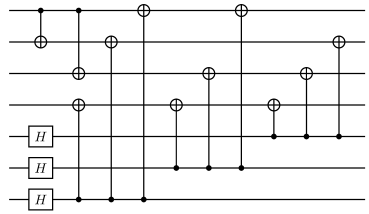

In [55]:
using Quantikz
ecirc = encoding_circuit(code)

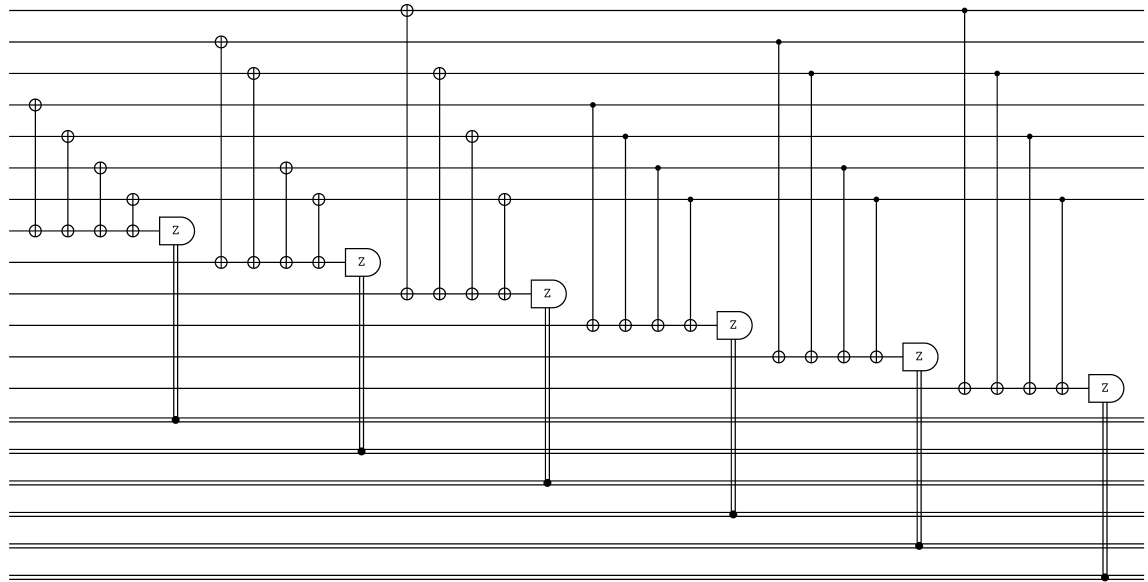

In [56]:
scirc = naive_syndrome_circuit(checks)

The last circuit that we will need is the circuit that measures the logical Z state, which can be obtained with the following few lines of code (shown below). It's not that important to understand why this is written the way it is. The main thing is that  `logicalzview()` is a function in `QuantumClifford.jl` that calculates the Z logical operator. 
* **Note:** There is a not a single logical Z operator - a logical operator multiplied by a stabilizer operator is still a logical operator. However the choice of logical operator behind the hood for the `faults_matrix()` function is the same as the one being used below, so there is not a problem in doing this.

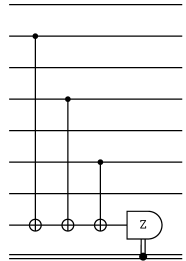

In [57]:
md = MixedDestabilizer(checks)
logview_Z = [ logicalzview(md);]
logcirc_Z = naive_syndrome_circuit(logview_Z)

The next thing to do is to combine these three circuits into one circuit that can be run:

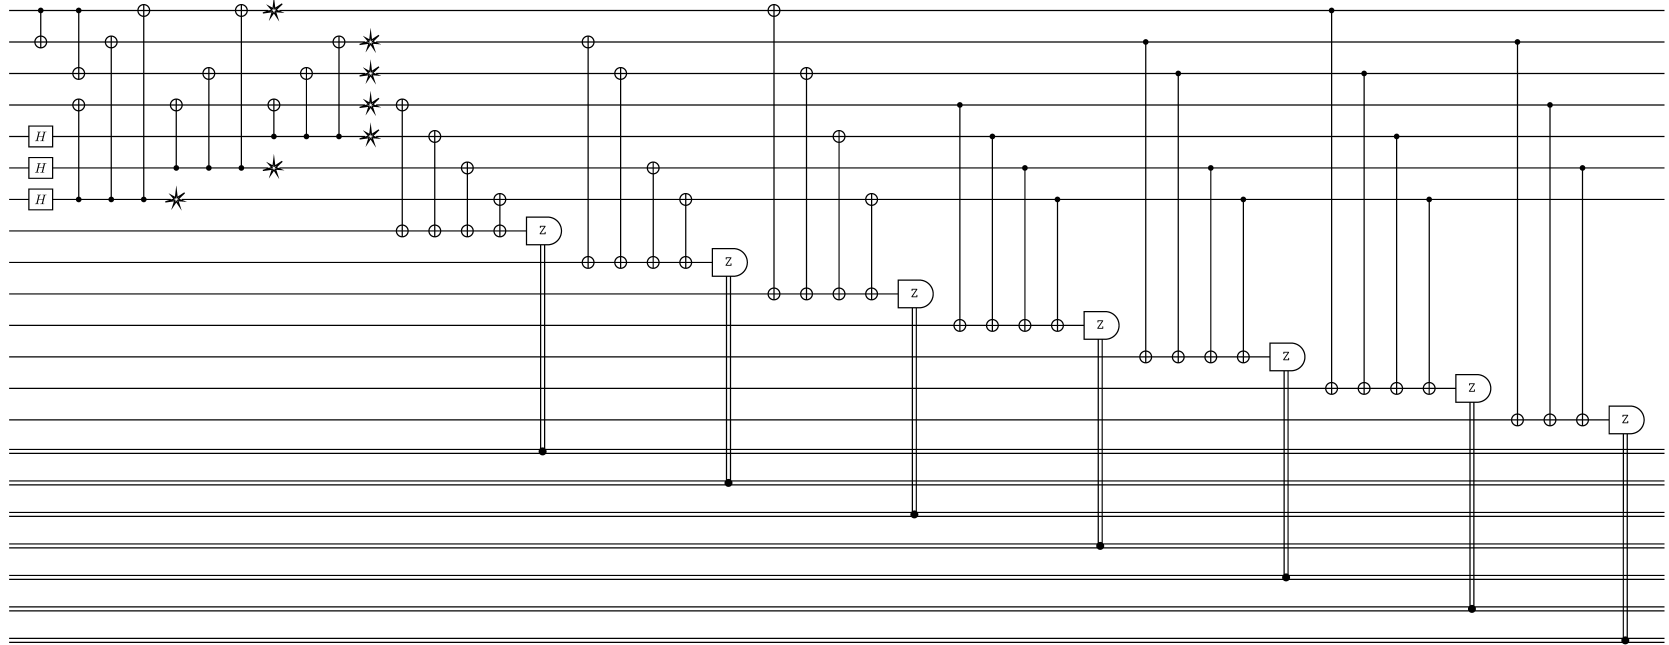

In [58]:
# Copy our syndrome circuit
circuit_Z = copy(scirc)
ancilbits , databits = size(checks)

# Adding on the Z logic circuit
for gate in logcirc_Z
    type = typeof(gate)
    if type == sMRZ
        push!(circuit_Z, sMRZ(gate.qubit+ancilbits, gate.bit+ancilbits))
    else 
        push!(circuit_Z, type(gate.q1, gate.q2+ancilbits))
    end
end

p_init = 0.06 # probability of error occuring after encoding but before the syndrome circuit
errors = [PauliError(i,p_init) for i in 1:databits] 
fullcircuit_Z = vcat(ecirc, errors, circuit_Z)

The output of the above cell should display an image of the full circuit. The stars after the encoding circuit are `PauliError` gates. When this circuit is run with a Pauli frame, a random Pauli error will be inserted in those spots with probability `p_init`.

Notice that now we have seventh measurement in our syndrome due to appending the logical Z measuring circuit. The seventh element of the syndrome will now read 0 when a logical Z flip has not occured, and 1 when it has. The first six values of the syndrome work the same as before.

# Pauli Frames with the logical Z circuit
This notebook will not focus on the details of how Pauli frame simulation works, but rather on how to use it in tandem with error correcting codes. As currently implemented (this very well might change in the future), `QuantumClifford.jl`'s pauli frames assume that for the provided circuit, measuring all zeroes is possible. However for error correcting codes, this is no problem, as a syndrome of all zeroes means no error!

All that needs to be understood about Pauli frames for this notebook is that a single pauli *frame* corresponds to one sample. For example, if we wanted 10 syndromes for the above circuit, we would set the number of frames to 10. In other words, the results from one frame are the results from running the circuit once. Here are some of the important function from `QuantumClifford.jl` related to Pauli frames:

*  `PauliFrame(number_of_frames, total_number_of_qubits, number_of_register_bits)` - This is the constructor. The second arguement is in our case, the number of data qubits + the number of ancillary qubits. The third argument is the number of ancillary qubits, as each ancilla is being measured.

*  `pftrajectories(pauli_frame, circuit)` - We provide a `PauliFrame` object as the first arguement and the circuit we want to run as the second. This function "runs" the simulation.

*  `pfmeasurements(pauli_frame)` - After running `pftrajectories()`, running this function on a `PauliFrame` object will return a matrix that has rows corresponding to each frame, and columns corresponding to each register.
Therefore, each row of this matrix can be treated as one simulated run of the circuit.



In [59]:
nframes = 10
# The + 1 is because we added one ancilllary bit and register for the logical measurement
frames = PauliFrame(nframes, databits+ancilbits+1, ancilbits+1)
pftrajectories(frames, fullcircuit_Z)
pfmeasurements(frames)

10×7 Matrix{Bool}:
 1  0  1  0  1  0  1
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 1  0  1  1  0  1  0
 0  0  0  0  0  0  0
 1  1  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0

Recall that part of `fullcircuit_Z` was random independent errors occuring on each of the seven data qubits with probability set above. Also recall that the first six columns refer to the orignal syndromes associated with the Steane 7 qubit and code and that the seventh column is measuring the logical Z state. Rows with a 0 in the seventh column did not experience a logical Z flip, and conversely rows whith 1 there *did* have their logical Z state flipped.

For convenience let's split this matrix into the syndromes that correspond to the original syndrome measuring circuit, and the measurements that give us information on the whether there was a logical Z flip or not.

In [60]:
syndromes = pfmeasurements(frames)[:, 1:ancilbits]

10×6 Matrix{Bool}:
 1  0  1  0  1  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 1  0  1  1  0  1
 0  0  0  0  0  0
 1  1  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0

In [61]:
logicalSyndromes = pfmeasurements(frames)[:, ancilbits+1]

10-element Vector{Bool}:
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0

All that's left to do (aside from plotting) is to write a loop to perform the decoding! This step follows exactly what was laid out earlier in the section on the `faults_matrix()` function.

In [62]:
decoded = 0
for i in 1:nframes
    row = syndromes[i,:]
    guess = get(lookup_table,row,nothing)
    if isnothing(guess)
        continue
    else
        result_Z = (O * stab_to_gf2(guess))[2] # [2] is to look only at the Z part
        if result_Z == logicalSyndromes[i]
            decoded += 1
        end
    end
end
z_error = 1 - decoded / nframes
print(z_error)

0.09999999999999998

The expected result for the Steane code is about 0.06, but if the sample size was too small of course we will not get that. Let's try again, but this time utilizing the efficiency of the Pauli Frames obtain a very large sample size. In other words, let's set the number of frames to 100,000!

In [63]:
nframes = 100_000
# The + 1 is because we added one ancilllary bit and register for the logical measurement
frames = PauliFrame(nframes, databits+ancilbits+1, ancilbits+1)
pftrajectories(frames, fullcircuit_Z)
syndromes = pfmeasurements(frames)[:, 1:ancilbits]
logicalSyndromes = pfmeasurements(frames)[:, ancilbits+1]

decoded = 0
for i in 1:nframes
    row = syndromes[i,:]
    guess = get(lookup_table,row,nothing)
    if isnothing(guess)
        continue
    else
        result_Z = (O * stab_to_gf2(guess))[2] # [2] is to look only at the Z part
        if result_Z == logicalSyndromes[i]
            decoded += 1
        end
    end
end
z_error = 1 - decoded / nframes
print(z_error)

0.05515000000000003

# Logical X circuit
We can do pretty much exactly the same thing in order to measure logical X flips. The only differences are that:
*  We now need to prepare the encoded qubits in the X basis. 
*  We need to use a circuit to measure the logical x state instead of the logical z state. 
*  We will now compare to the first element of the resulting vector we get from multipling the fault matrix by our prediction.

Points 2 and 3 are very straightforward changes to the julia code, however point 1 sounds a bit complicated. *It is not*. Since the convention in QuantumClifford is that the first qubit is the one being encoded, we simply need to apply a single Hadamard gate to that qubit before running the encoding circuit. Below, we will create the full X circuit:

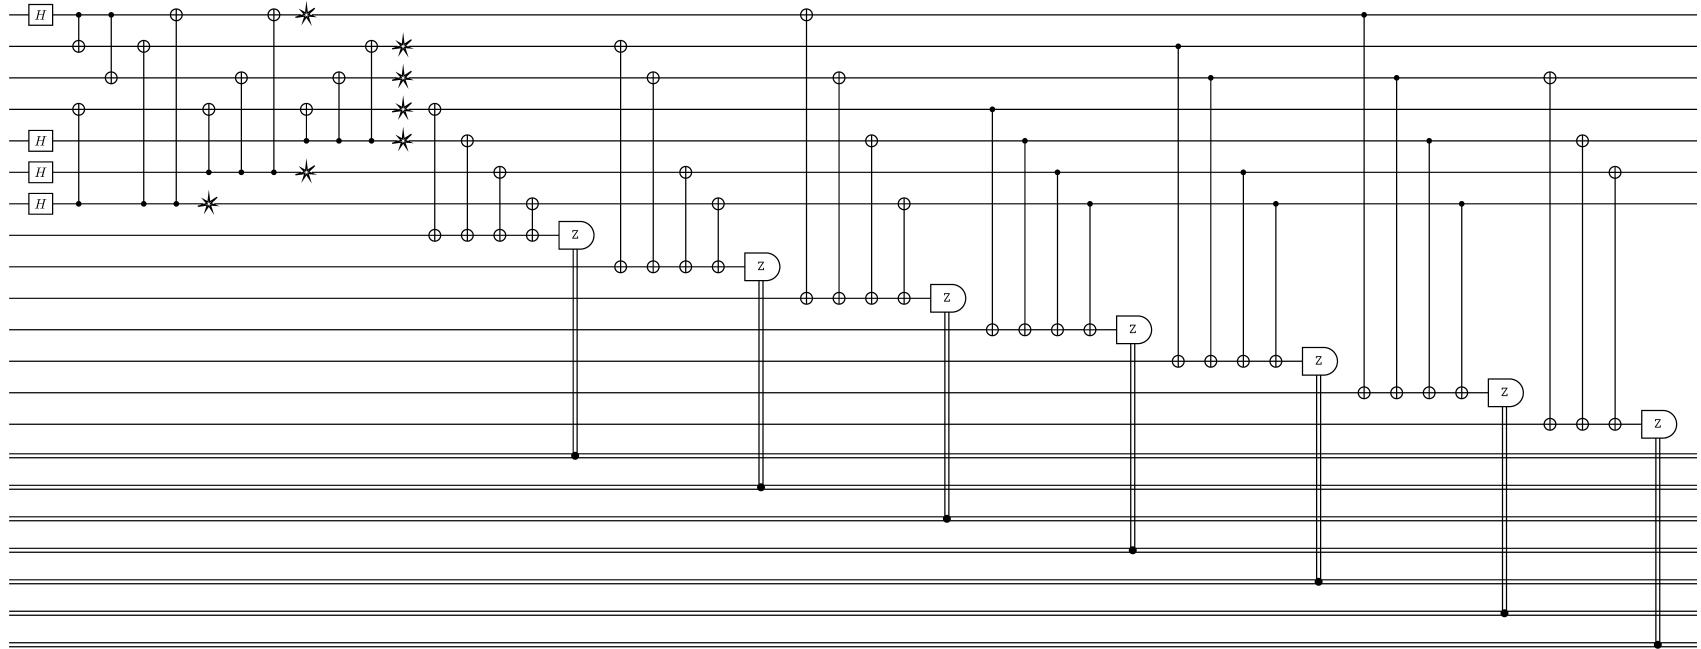

In [64]:
# To initialize in the x basis
pre_X = sHadamard(1) 

# Creating the logical X measuring circuit
md = MixedDestabilizer(checks)
logview_X = [ logicalxview(md);]
logcirc_X = naive_syndrome_circuit(logview_X)

# Copy our syndrome circuit
circuit_X = copy(scirc)
ancilbits , databits = size(checks)

# Adding on the X logical circuit to the syndrome circuit
for gate in logcirc_X
    type = typeof(gate)
    if type == sMRZ
        push!(circuit_X, sMRZ(gate.qubit+ancilbits, gate.bit+ancilbits))
    else 
        push!(circuit_X, type(gate.q1, gate.q2+ancilbits))
    end
end

p_init = 0.06 # probability of error occuring after encoding but before the syndrome circuit
errors = [PauliError(i,p_init) for i in 1:databits] 
fullcircuit_X = vcat(pre_X, ecirc, errors, circuit_X)

The above image should look very similiar to the full Z circuit, with the only differences being the addition Hadamard gate at the beginning for initializing in the X basis, and the logical measurement of course being different at the end.

We can now go ahead and simulate it with Pauli frames in exactly the same way. The only thing to notice is that we our now comparing to the first (and therefore X) component of the resulting vector from multiping the fault matrix with our guess. (In the Z simulation, we were looking at the second component.)

In [65]:
nframes = 100_000
# The + 1 is because we added one ancilllary bit and register for the logical measurement
frames = PauliFrame(nframes, databits+ancilbits+1, ancilbits+1)
pftrajectories(frames, fullcircuit_X)
syndromes = pfmeasurements(frames)[:, 1:ancilbits]
logicalSyndromes = pfmeasurements(frames)[:, ancilbits+1]

decoded = 0
for i in 1:nframes
    row = syndromes[i,:]
    guess = get(lookup_table,row,nothing)
    if isnothing(guess)
        continue
    else
        result_X = (O * stab_to_gf2(guess))[1] # [1] is to look only at the X part
        if result_X == logicalSyndromes[i]
            decoded += 1
        end
    end
end
x_error = 1 - decoded / nframes
print(x_error)

0.05432999999999999

# Plotting
To generate plots we will use the same function we used in the previous notebook. However, because we are calculating two different error rates, we will have two plots. To deal with these two plots, a little more code was needed than in the previous notebook just for tyings things together nicely. First the plotting function:

In [66]:
using CairoMakie
function plot_code_performance(error_rates, post_ec_error_rates; title="")
    f = Figure(resolution=(500,300))
    ax = f[1,1] = Axis(f, xlabel="single (qu)bit error rate",title=title)
    ax.aspect = DataAspect()
    lim = max(error_rates[end],post_ec_error_rates[end])
    lines!([0,lim], [0,lim], label="single bit", color=:black)
    plot!(error_rates, post_ec_error_rates, label="after decoding", color=:black)
    xlims!(0,lim)
    ylims!(0,lim)
    f[1,2] = Legend(f, ax, "Error Rates")
    f
end

plot_code_performance (generic function with 1 method)

Now a function that uses what we did in the previous section to generate an error rate for a given physical error probability, `p_init`:

In [67]:
function evaluate_code_decoder_w_ecirc_pf(checks::Stabilizer, ecirc, scirc, p_init ; nframes=10_000)   
    lookup_table = create_lookup_table(checks)
    O = faults_matrix(checks)
    circuit_Z = copy(scirc)
    circuit_X = copy(scirc)
    pre_X = sHadamard(1) # to initialize in x basis
    
    ancil_qubits, data_qubits = size(checks) 
    regbits = ancil_qubits # In most cases these will be the same 

    md = MixedDestabilizer(checks)
    logview_Z = [ logicalzview(md);]
    logcirc_Z = naive_syndrome_circuit(logview_Z)

    logview_X = [ logicalxview(md);]
    logcirc_X = naive_syndrome_circuit(logview_X)
    
    # Z logic circuit
    for gate in logcirc_Z
        type = typeof(gate)
        if type == sMRZ
            push!(circuit_Z, sMRZ(gate.qubit+regbits, gate.bit+regbits))
        else 
            push!(circuit_Z, type(gate.q1, gate.q2+regbits))
        end
    end

   # X logic circuit
    for gate in logcirc_X
        type = typeof(gate)
        if type == sMRZ
            push!(circuit_X, sMRZ(gate.qubit+regbits, gate.bit+regbits))
        else 
            push!(circuit_X, type(gate.q1, gate.q2+regbits))
        end
    end

    # Z simulation
    errors = [PauliError(i,p_init) for i in 1:data_qubits]
    fullcircuit_Z = vcat(ecirc, errors, circuit_Z)

    frames = PauliFrame(nframes, data_qubits + ancil_qubits + 1, regbits + 1)
    pftrajectories(frames, fullcircuit_Z)
    syndromes = pfmeasurements(frames)[:, 1:regbits]
    logicalSyndromes = pfmeasurements(frames)[:, regbits+1]

    decoded = 0
    for i in 1:nframes
        row = syndromes[i,:]
        guess = get(lookup_table,row,nothing)
        if isnothing(guess)
            continue
        else
            result_Z = (O * stab_to_gf2(guess))[2]
            if result_Z == logicalSyndromes[i]
                decoded += 1
            end
        end
    end
    z_error = 1 - decoded / nframes
    
    # X simulation
    fullcircuit_X = vcat(pre_X, ecirc, errors, circuit_X)
    frames = PauliFrame(nframes, data_qubits + ancil_qubits + 1, regbits + 1)
    pftrajectories(frames, fullcircuit_X)
    syndromes = pfmeasurements(frames)[:, 1:regbits]
    logicalSyndromes = pfmeasurements(frames)[:, regbits+1]

    decoded = 0
    for i in 1:nframes
        row = syndromes[i,:]
        guess = get(lookup_table,row,nothing)
        if isnothing(guess)
            continue
        else
            result_X = (O * stab_to_gf2(guess))[1]
            if result_X == logicalSyndromes[i]
                decoded += 1
            end
        end
    end
    x_error = 1 - decoded / nframes

    return x_error, z_error
end

evaluate_code_decoder_w_ecirc_pf (generic function with 1 method)

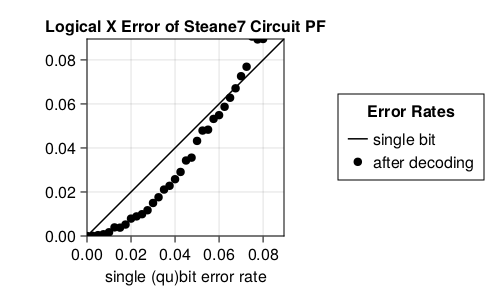

In [68]:
code = Steane7()
scirc = naive_syndrome_circuit(code)
ecirc = encoding_circuit(code)
checks = parity_checks(code)

# Will check p_init values ranging from 0 to 0.08, with a step size of 0.0025
error_rates = 0.000:0.0025:0.08

# Data to plot
post_ec_error_rates = [evaluate_code_decoder_w_ecirc_pf(checks, ecirc, scirc, p) for p in error_rates]
x_error = [post_ec_error_rates[i][1] for i in eachindex(post_ec_error_rates)]
z_error = [post_ec_error_rates[i][2] for i in eachindex(post_ec_error_rates)]

# X plot
name = string(typeof(code))
f_x = plot_code_performance(error_rates, x_error,title="Logical X Error of "*name*" Circuit PF")

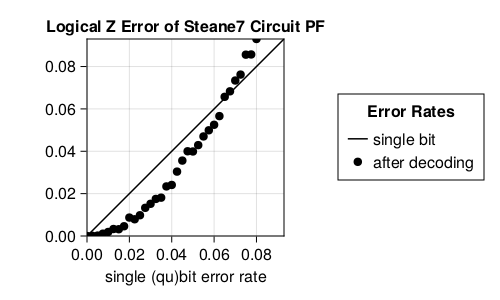

In [69]:
# Z plot
f_z = plot_code_performance(error_rates, z_error,title="Logical Z Error of "*name*" Circuit PF")

If everything worked, both of these two plots should look like the one we created in the previous notebook! 
*  **Note:** The logical X and Z plots won't always look the same. (Explain more about why these look the way they do)